# EDA

This notebook is reading 10k_synthea_covid19_csv to analyze those that are similar to the Enclave files:
    
    Enclave Files:
    
    Demographics: Person
    Conditions: Condition
    Observations: Observations
    Diagnosis: Dem, Cond, Obse
    Drugs
    
    Synthea Files:
    
    Conditions: Conditions
    Observations: Observations
    Medications: Drugs
    Patients: Demographics
    Diagnosis: Patients, Cond, Obse
    




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer,StandardScaler
from pyspark.ml import Pipeline

from pyspark.sql.functions import col, when, sum, first,  countDistinct, max
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.stat import Statistics 
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import Window
import pyspark.sql.functions as f

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_patients = pd.read_csv('../data/patients.csv')
df_conditions = pd.read_csv('../data/conditions.csv')
df_observations = pd.read_csv('../data/observations.csv')
df_medications = pd.read_csv('../data/medications.csv')

### Demographics - Patients

Enclave Demographics Columns

person_id,
pasc_code_after_four_weeks,

age,
ageGroup_infant,
ageGroup_toddler,
ageGroup_adolescent,
ageGroup_youngAd,
ageGroup_adult,
ageGroup_olderAd,
ageGroup_elderly,

gender_fem,
gender_mal,
gender_unk,

race_none,
race_mult,
race_unk,
race_whi,
race_his,
race_asi,
race_bla,
race_nat,
race_ind,

ethnicity_unk,
ethnicity_his,
ethnicity_notHis,

In [4]:
cols = ['Id', 'BIRTHDATE', 'RACE','ETHNICITY','GENDER']
df = df_patients[cols]

In [5]:
df['BIRTHDATE']=df['BIRTHDATE'].astype(str).str[0:4].astype(int)
df['age'] = 2021 - df['BIRTHDATE']

In [6]:
df

,Id,BIRTHDATE,RACE,ETHNICITY,GENDER,age
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,2017,white,nonhispanic,M,4
1,067318a4-db8f-447f-8b6e-f2f61e9baaa5,2016,white,nonhispanic,F,5
2,ae9efba3-ddc4-43f9-a781-f72019388548,1992,white,nonhispanic,M,29
3,199c586f-af16-4091-9998-ee4cfc02ee7a,2004,white,nonhispanic,F,17
4,353016ea-a0ff-4154-85bb-1cf8b6cedf20,1996,white,nonhispanic,M,25
...,...,...,...,...,...,...
12347,eec72396-d10e-4b8e-8fb6-25fc1e396031,1962,asian,nonhispanic,F,59
12348,3daf2b90-c439-469f-bb44-fb6109c6a8a7,1918,white,nonhispanic,F,103
12349,cb03d88e-7f08-46a1-be78-70d9fe8262a7,1918,white,nonhispanic,F,103
12350,435be43f-cb57-442f-aeb2-51018b030ed0,1918,white,nonhispanic,F,103


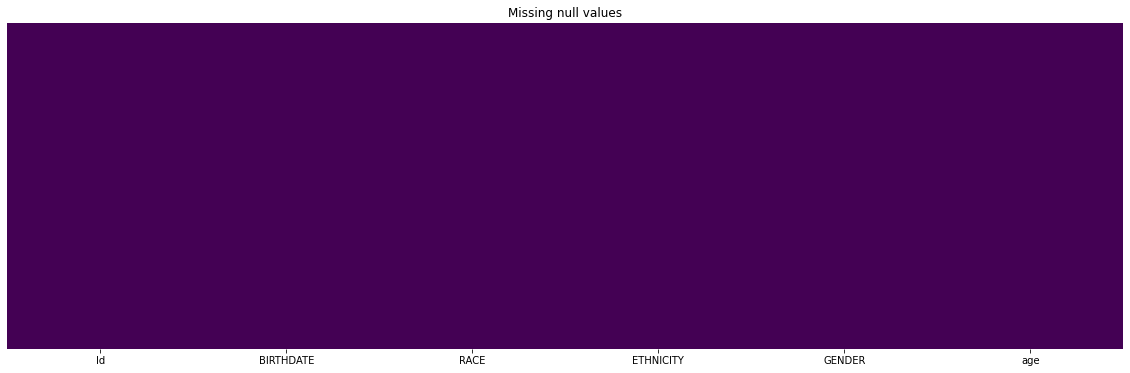

In [7]:
plt.rcParams['figure.figsize'] = (20,6)
sns.heatmap(df.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

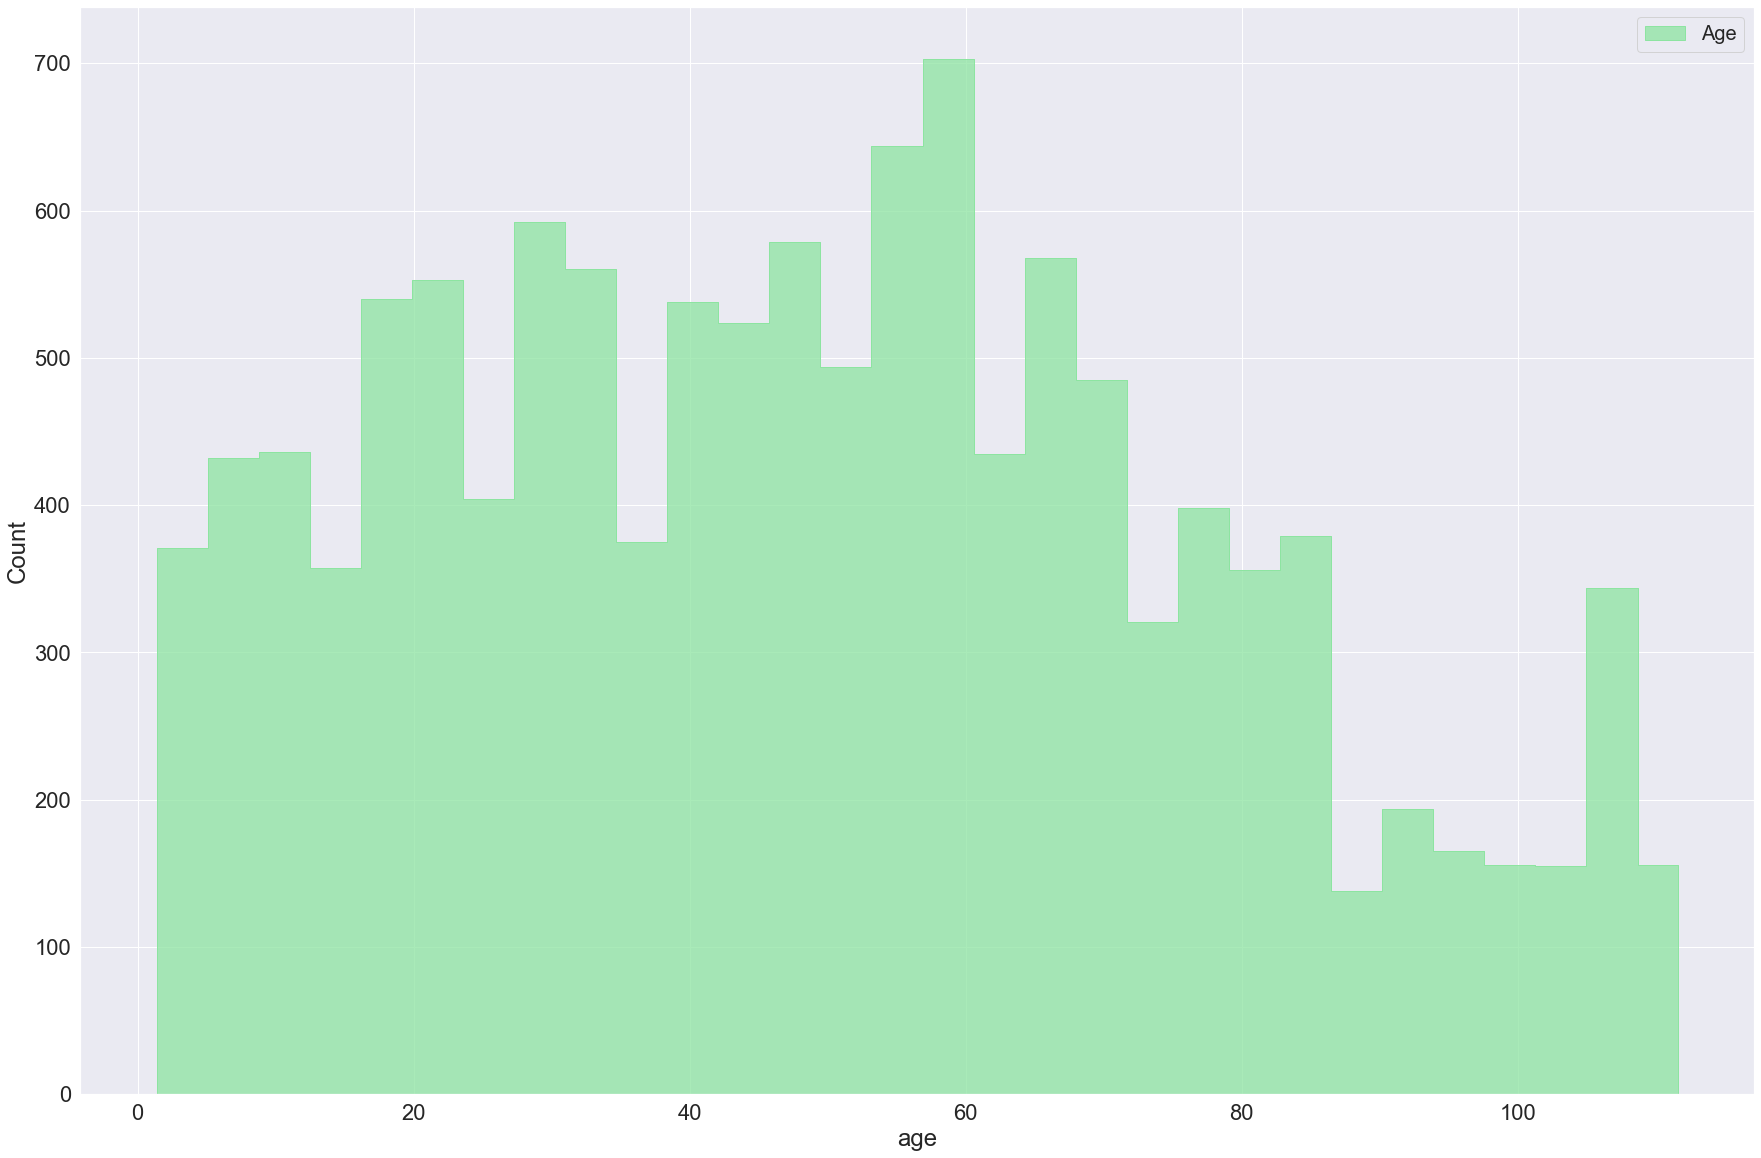

In [8]:
sns.set(rc={'figure.figsize':(30,20)})
sns.set(font_scale=2)

g = sns.histplot(data=df, x='age', shrink=0.8, color='#8de4a1', label='Age', element="step", stat="count")

plt.legend(loc='upper right', fontsize=20)
plt.show()

### Age

In [9]:
df['ageGroup_infant'] = 1
df['ageGroup_toddler'] = 1
df['ageGroup_adolescent'] = 1
df['ageGroup_youngAd'] = 1
df['ageGroup_adult'] = 1
df['ageGroup_olderAd'] = 1
df['ageGroup_elderly'] = 1


df.loc[df['age'] > 2, 'ageGroup_infant'] = 0
df.loc[(df['age'] <= 2) & (df['age'] < 4), 'ageGroup_toddler'] = 0
df.loc[(df['age'] <= 4) & (df['age'] < 14), 'ageGroup_adolescent'] = 0
df.loc[(df['age'] <= 14) & (df['age'] < 30), 'ageGroup_youngAd'] = 0
df.loc[(df['age'] <= 30) & (df['age'] < 50), 'ageGroup_adult'] = 0
df.loc[(df['age'] <= 50) & (df['age'] < 90), 'ageGroup_olderAd'] = 0
df.loc[df['age'] <= 90, 'ageGroup_elderly'] = 0

### Gender, Race, Ethnicity

In [10]:
print(df['RACE'].unique())
print(df['GENDER'].unique())
print(df['ETHNICITY'].unique())

['white' 'native' 'asian' 'black' 'other']
['M' 'F']
['nonhispanic' 'hispanic']


In [11]:
df['race_white'] = 1
df['race_native'] = 1
df['race_asian'] = 1
df['race_black'] = 1
df['race_other'] = 1
df['gender_M'] = 1
df['gender_F'] = 1
df['ethnicity_non'] = 1
df['ethnicity_his'] = 1


df.loc[df['RACE'] == 'white', 'race_white'] = 0
df.loc[(df['RACE'] == 'native') , 'race_native'] = 0
df.loc[(df['RACE'] == 'asian') , 'race_asian'] = 0
df.loc[(df['RACE'] == 'black') , 'race_black'] = 0
df.loc[(df['RACE'] == 'other') , 'race_other'] = 0
df.loc[(df['GENDER'] == 'M') , 'gender_M'] = 0
df.loc[df['GENDER'] == 'F', 'gender_F'] = 0
df.loc[(df['ETHNICITY'] == 'nonhispanic') , 'ethnicity_non'] = 0
df.loc[df['ETHNICITY'] == 'hispanic', 'ethnicity_his'] = 0
df =df.drop(['BIRTHDATE', 'RACE', 'ETHNICITY', 'GENDER', 'age'], axis =1)


In [12]:
df['Id']=df['Id'].astype(str)
df.rename(columns = {'Id':'PATIENT'}, inplace = True)
df_patients = df
df_patients.to_excel("output/Patients_Demographics_Synthea.xlsx") 

### Conditions

In [13]:
df_conditions.dtypes

START          object
STOP           object
PATIENT        object
ENCOUNTER      object
CODE            int64
DESCRIPTION    object
dtype: object

In [14]:
df_conditions['PATIENT']=df_conditions['PATIENT'].astype(str)
df_conditions['START'] = pd.to_datetime(df_conditions['START'])
df_conditions['STOP']=pd.to_datetime(df_conditions['STOP'])
df_conditions['DESCRIPTION']=df_conditions['DESCRIPTION'].astype(str)
df_conditions['DURATION'] = df_conditions['STOP'] - df_conditions['START']
df_conditions['DURATION']= df_conditions['DURATION']/ np.timedelta64(1, 'D')
df_conditions['TOTAL_DURATION_CON'] = df_conditions.groupby(['PATIENT','CODE'], sort=False)['DURATION'].transform('sum')
df_conditions =df_conditions.drop(['START', 'STOP', 'DURATION'], axis=1)

In [15]:
df_conditions['COD_PER_ENCOUNTER_CON'] = df_conditions.groupby(['PATIENT','ENCOUNTER'], sort=False)['CODE'].transform('count')
#this encounter they went for only one code 'condition'
df_conditions['ENCOUNTER_PER_CON'] = df_conditions.groupby(['PATIENT','CODE'], sort=False)['ENCOUNTER'].transform('count')
df_conditions = df_conditions.drop(['ENCOUNTER'], axis=1)

In [16]:
df_conditions = df_conditions.drop_duplicates()
df_conditions.rename(columns = {'CODE':'CONDITION_CODE', 'DESCRIPTION':'CONDITION_DESC'}, inplace = True)
df_conditions.to_excel("output/Conditions_Synthea.xlsx") 

In [17]:
df_covid = df_conditions.loc[(df_conditions['CONDITION_CODE']) == 840539006]
df_covid.to_excel("output/CovidPatients_Synthea.xlsx") 
df_con_dem = df_covid.merge(df_patients, how = 'right', on = 'PATIENT')
df_con_dem.to_excel("output/Patients_Conditions_Synthea.xlsx") 

In [18]:
df_conditions
#multiple conditions per patient

,PATIENT,CONDITION_CODE,CONDITION_DESC,TOTAL_DURATION_CON,COD_PER_ENCOUNTER_CON,ENCOUNTER_PER_CON
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,65363002,Otitis media,259.0,1,2
2,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,386661006,Fever (finding),29.0,3,1
3,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,Suspected COVID-19,0.0,3,1
4,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840539006,COVID-19,29.0,3,1
5,067318a4-db8f-447f-8b6e-f2f61e9baaa5,44465007,Sprain of ankle,14.0,1,1
...,...,...,...,...,...,...
114539,2712205f-755e-4897-acb3-926895b7d635,248595008,Sputum finding (finding),28.0,6,1
114540,2712205f-755e-4897-acb3-926895b7d635,68962001,Muscle pain (finding),28.0,6,1
114541,2712205f-755e-4897-acb3-926895b7d635,57676002,Joint pain (finding),28.0,6,1
114542,2712205f-755e-4897-acb3-926895b7d635,840544004,Suspected COVID-19,0.0,6,1


### Observations

In [19]:
df_observations = df_observations.drop(['DATE', 'VALUE', 'UNITS', 'TYPE'], axis=1)

In [20]:
df_observations.to_csv("output/Observations_Synthea.csv") 
df_obs_dem = df_observations.merge(df_patients, how = 'right', on = 'PATIENT')
df_con_dem.to_excel("output/Patients_Observations_Synthea.xlsx") 

In [21]:
df_observations.rename(columns = {'CODE':'OBSERVATION_CODE', 'DESCRIPTION':'OBSERVATION_DESC'}, inplace = True)

In [22]:
df_obs_dem

,PATIENT,ENCOUNTER,CODE,DESCRIPTION,ageGroup_infant,ageGroup_toddler,ageGroup_adolescent,ageGroup_youngAd,ageGroup_adult,ageGroup_olderAd,ageGroup_elderly,race_white,race_native,race_asian,race_black,race_other,gender_M,gender_F,ethnicity_non,ethnicity_his
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,6a74fdef-2287-44bf-b9e7-18012376faca,8302-2,Body Height,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1
1,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,6a74fdef-2287-44bf-b9e7-18012376faca,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1
2,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,6a74fdef-2287-44bf-b9e7-18012376faca,29463-7,Body Weight,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1
3,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,6a74fdef-2287-44bf-b9e7-18012376faca,77606-2,Weight-for-length Per age and sex,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1
4,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,6a74fdef-2287-44bf-b9e7-18012376faca,9843-4,Head Occipital-frontal circumference,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659745,2712205f-755e-4897-acb3-926895b7d635,NaN,QALY,QALY,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
1659746,2712205f-755e-4897-acb3-926895b7d635,NaN,DALY,DALY,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
1659747,2712205f-755e-4897-acb3-926895b7d635,NaN,DALY,DALY,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
1659748,2712205f-755e-4897-acb3-926895b7d635,NaN,QOLS,QOLS,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1


### Medications - Drugs

In [23]:
df_medications = df_medications.drop(['PAYER', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST'], axis=1)

In [24]:
df_medications['PATIENT']=df_medications['PATIENT'].astype(str)
df_medications['START'] = pd.to_datetime(df_medications['START'])
df_medications['STOP']=pd.to_datetime(df_medications['STOP'])
df_medications['DESCRIPTION']=df_medications['DESCRIPTION'].astype(str)
df_medications['DURATION'] = df_medications['STOP'] - df_medications['START']
df_medications['DURATION']= df_medications['DURATION']/ np.timedelta64(1, 'D')
df_medications['TOTAL_DURATION_MED'] = df_medications.groupby(['PATIENT','CODE'], sort=False)['DURATION'].transform('sum')
df_medications= df_medications.drop(['START', 'STOP', 'DURATION'], axis=1)

In [25]:
df_medications['OBS_PER_ENCOUNTER_MED'] = df_medications.groupby(['PATIENT','ENCOUNTER'], sort=False)['CODE'].transform('count')
#this encounter they went for only one code 'condition'
df_medications['ENCOUNTER_PER_MED'] = df_medications.groupby(['PATIENT','CODE'], sort=False)['ENCOUNTER'].transform('count')
df_medications = df_medications.drop(['ENCOUNTER'], axis=1)
df_medications.rename(columns = {'CODE':'MEDICATION_CODE', 'DESCRIPTION':'MEDICATION_DESC'}, inplace = True)
df_medications.to_csv("output/Medications_Drugs_Synthea.csv") 
